# Project: Investigate FBI gun data to understand which variables are most associated with high gun per capita

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project I investigate the FBI's National Instant Criminal Background Check System (NICS), which is used to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops will call into this system to ensure that each customer does not have a criminal record or isn't otherwise ineligible to make a purchase. 

The dataset (*gun_data.xls*) contains the number of firearm checks by month, state and type. It is completed by another dataset (*U.S. Census Data.csv*) which contains several census variables at the state level.

Over the course of the report, I will try to answer three questions:
* **What is the overall trend of gun purchases?**
* **Which states have high gun per capita?**
* **Are low education, low income or high poverty associated with high gun per capita?**

In [2]:
# import packages and magic command to view the plots in the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### Assessing and cleaning the *gun-data.xls* dataset

First I convert the dataset into a csv file using Excel "Save As" function and name it *gun_raw_data.csv*.

In [4]:
# load data and inspect a few lines
df_gun = pd.read_csv('gun_raw_data.csv')
df_gun.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


>Each row regroups the number of firearm checks by type for a specific month (first column) and a specific state (second column). Since I'm only interested in the total number of firearm checks, I drop all the unnecessary columns.

In [5]:
# drop all columns except 'month','state' and 'totals'
df_gun.drop(df_gun.iloc[:,2:26].columns, axis=1, inplace=True)
df_gun.head()

,month,state,totals
0,2017-09,Alabama,32019
1,2017-09,Alaska,6303
2,2017-09,Arizona,28394
3,2017-09,Arkansas,17747
4,2017-09,California,123506


In [6]:
# inspect datatypes
df_gun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 3 columns):
month     12485 non-null object
state     12485 non-null object
totals    12485 non-null int64
dtypes: int64(1), object(2)
memory usage: 292.7+ KB


> There are no missing values. The *state* and *totals* columns have the correct data type: string and integer, respectively. However, the *month* column does not. It should be date time object instead of string.

In [7]:
# change 'month' column datatype from string to date time object
df_gun['month'] = pd.to_datetime(df_gun['month'])
df_gun.dtypes

month     datetime64[ns]
state             object
totals             int64
dtype: object

Now all columns have the right data type and we can save the cleaned dataset as *gun_clean_data.csv*. 

In [8]:
# save clean dataset
df_gun.to_csv('gun_clean_data.csv', index=False)

### Assessing and cleaning the *U.S. Census Data.csv* dataset

First, I renamed the dataset *census_raw_data.csv*.

In [9]:
# load data and inspect a few lines
df_census = pd.read_csv('census_raw_data.csv')
df_census.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


>The columns are the states (except the first two) and the rows are the different statistics about the state populations.

In [10]:
# know the dimensions of the dataset and inspect the datatypes
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
Fact              80 non-null object
Fact Note         28 non-null object
Alabama           65 non-null object
Alaska            65 non-null object
Arizona           65 non-null object
Arkansas          65 non-null object
California        65 non-null object
Colorado          65 non-null object
Connecticut       65 non-null object
Delaware          65 non-null object
Florida           65 non-null object
Georgia           65 non-null object
Hawaii            65 non-null object
Idaho             65 non-null object
Illinois          65 non-null object
Indiana           65 non-null object
Iowa              65 non-null object
Kansas            65 non-null object
Kentucky          65 non-null object
Louisiana         65 non-null object
Maine             65 non-null object
Maryland          65 non-null object
Massachusetts     65 non-null object
Michigan          65 non-null object
Minnesota

>There is the same number of non-null values for all columns (the US states) except the first two.

In [11]:
# check last 25 lines
df_census.tail(25)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
60,"Veteran-owned firms, 2012",NaN,"41,943","7,953","46,780","25,915","252,377","51,722","31,056","7,206",...,8604,59379,"213,590","18,754","8,237","76,434","49,331","12,912","39,830","6,470"
61,"Nonveteran-owned firms, 2012",NaN,"316,984","56,091","427,582","192,988","3,176,341","469,524","281,182","60,318",...,66219,469392,"2,057,218","219,807","63,317","548,439","461,401","94,960","370,755","51,353"
62,"Population per square mile, 2010",NaN,94.4,1.2,56.3,56,239.1,48.5,738.1,460.8,...,10.7,153.9,96.3,33.6,67.9,202.6,101.2,77.1,105,5.8
63,"Land area in square miles, 2010",NaN,"50,645.33","570,640.95","113,594.08","52,035.48","155,779.22","103,641.89","4,842.36","1,948.54",...,75811,41234.9,"261,231.71","82,169.62","9,216.66","39,490.09","66,455.52","24,038.21","54,157.80","97,093.14"
64,FIPS Code,NaN,"""01""","""02""","""04""","""05""","""06""","""08""","""09""","""10""",...,"""46""","""47""","""48""","""49""","""50""","""51""","""53""","""54""","""55""","""56"""
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NOTE: FIPS Code values are enclosed in quotes ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Value Notes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,1,Includes data not distributed by county.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


>From line 65 to 84, there is no data but only explanatory notes. I drop these lines and the column "Fact Note" as well, which also contains no data but only notes.

In [12]:
# drop lines 65 to 84 and 'Fact Note' column
df_census.drop(range(65,85), axis=0, inplace=True)
df_census.drop('Fact Note', axis=1, inplace=True)
df_census.tail()

,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
60,"Veteran-owned firms, 2012","41,943","7,953","46,780","25,915","252,377","51,722","31,056","7,206","185,756",...,8604,59379,"213,590","18,754","8,237","76,434","49,331","12,912","39,830","6,470"
61,"Nonveteran-owned firms, 2012","316,984","56,091","427,582","192,988","3,176,341","469,524","281,182","60,318","1,846,686",...,66219,469392,"2,057,218","219,807","63,317","548,439","461,401","94,960","370,755","51,353"
62,"Population per square mile, 2010",94.4,1.2,56.3,56,239.1,48.5,738.1,460.8,350.6,...,10.7,153.9,96.3,33.6,67.9,202.6,101.2,77.1,105,5.8
63,"Land area in square miles, 2010","50,645.33","570,640.95","113,594.08","52,035.48","155,779.22","103,641.89","4,842.36","1,948.54","53,624.76",...,75811,41234.9,"261,231.71","82,169.62","9,216.66","39,490.09","66,455.52","24,038.21","54,157.80","97,093.14"
64,FIPS Code,"""01""","""02""","""04""","""05""","""06""","""08""","""09""","""10""","""12""",...,"""46""","""47""","""48""","""49""","""50""","""51""","""53""","""54""","""55""","""56"""


Then I examine the different statistics (rows in the dataset), and keep only those useful to anwser my questions.

In [13]:
# drop unncessery columns
df_census.drop(np.r_[1:35,36:47,48,50:65], axis=0, inplace=True)
df_census.head()

,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)","4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065","20,612,439",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
35,"Bachelor's degree or higher, percent of person...",23.50%,28.00%,27.50%,21.10%,31.40%,38.10%,37.60%,30.00%,27.30%,...,0.27,0.249,27.60%,31.10%,36.00%,36.30%,32.90%,19.20%,27.80%,25.70%
47,"Median household income (in 2015 dollars), 201...","$43,623","$72,515","$50,255","$41,371","$61,818","$60,629","$70,331","$60,509","$47,507",...,50957,45219,"$53,207","$60,727","$55,176","$65,015","$61,062","$41,751","$53,357","$58,840"
49,"Persons in poverty, percent",17.10%,9.90%,16.40%,17.20%,14.30%,11.00%,9.80%,11.70%,14.70%,...,0.133,0.158,15.60%,10.20%,11.90%,11.00%,11.30%,17.90%,11.80%,11.30%


>Now we only have the statistics that we will use for the exploratory analysis.

In [14]:
#inspect data types
df_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 49
Data columns (total 51 columns):
Fact              4 non-null object
Alabama           4 non-null object
Alaska            4 non-null object
Arizona           4 non-null object
Arkansas          4 non-null object
California        4 non-null object
Colorado          4 non-null object
Connecticut       4 non-null object
Delaware          4 non-null object
Florida           4 non-null object
Georgia           4 non-null object
Hawaii            4 non-null object
Idaho             4 non-null object
Illinois          4 non-null object
Indiana           4 non-null object
Iowa              4 non-null object
Kansas            4 non-null object
Kentucky          4 non-null object
Louisiana         4 non-null object
Maine             4 non-null object
Maryland          4 non-null object
Massachusetts     4 non-null object
Michigan          4 non-null object
Minnesota         4 non-null object
Mississippi       4 non-null objec

>There are no missing values. However, the data type for each state should be float and not string.

First I save the file so that it includes the changes made so far.

In [15]:
# save dataset
df_census.to_csv('census_raw_data.csv', index=False)

Then I open the file in Excel and change the format of all numeric data to 'General' so that it doesn't include commas and it has the correct data type (float). I save and exit the file.

In [16]:
# load data again after changes made to the csv file
df_census = pd.read_csv('census_raw_data.csv')
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 51 columns):
Fact              4 non-null object
Alabama           4 non-null float64
Alaska            4 non-null float64
Arizona           4 non-null float64
Arkansas          4 non-null float64
California        4 non-null float64
Colorado          4 non-null float64
Connecticut       4 non-null float64
Delaware          4 non-null float64
Florida           4 non-null float64
Georgia           4 non-null float64
Hawaii            4 non-null float64
Idaho             4 non-null float64
Illinois          4 non-null float64
Indiana           4 non-null float64
Iowa              4 non-null float64
Kansas            4 non-null float64
Kentucky          4 non-null float64
Louisiana         4 non-null float64
Maine             4 non-null float64
Maryland          4 non-null float64
Massachusetts     4 non-null float64
Michigan          4 non-null float64
Minnesota         4 non-null float64
Mississippi 

Now the state data points have the correct data type. I can save the cleaned dataset as *census_clean_data.csv*.

In [17]:
# save clean dataset
df_census.to_csv('census_clean_data.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis

### What is the overall trend of gun purchases?

First we make the assumption that the number of firearm checks is a good proxy to estimate the number of gun purchases since everytime a gun is purchased, there is a check. However, the actual number of gun purchases will always be lower than the number of checks because the purchase can be refused depending on the result of the check.

To answer the question, I have to group the data by period to have an idea of the historical trend.

In [18]:
# group data by month
df_gun.groupby('month').sum()

,totals
month,
1998-11-01,21176
1998-12-01,870722
1999-01-01,585974
1999-02-01,690215
1999-03-01,741687
1999-04-01,638666
1999-05-01,569220
1999-06-01,564912
1999-07-01,579634


>I need to group the data by year in order to know how many gun purchases were made annually.

In [19]:
# group by year
df_gun_yearly = df_gun.groupby(df_gun['month'].dt.year).sum()
df_gun.groupby(df_gun['month'].dt.year).sum()

,totals
month,
1998,891898
1999,9043747
2000,8427096
2001,8820045
2002,8367069
2003,8402244
2004,8579891
2005,8867055
2006,9993057


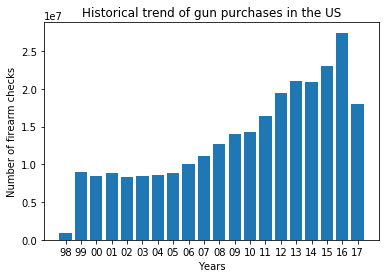

In [20]:
# create bar chart
locations = range(1,21)
heights = df_gun_yearly['totals']
labels = ['98','99','00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17']
          
plt.bar(locations,heights, tick_label=labels);
plt.title('Historical trend of gun purchases in the US')
plt.xlabel('Years')
plt.ylabel('Number of firearm checks');

### Which states have high gun per capita?

In order to answer this question, we need to compute the gun per capita for each state. Gun per capita can be approximated by evaluating the total number of firearms checks over a certain period, and dividing this number by the population estimate at the end of the period.

In [21]:
# group by state
df_gun_state = df_gun.groupby('state').sum()
df_gun_state

,totals
state,
Alabama,6706079
Alaska,1137643
Arizona,4425714
Arkansas,3752633
California,19014063
Colorado,6058482
Connecticut,3168126
Delaware,491369
District of Columbia,5601


There are states for which we do not have population estimates, so we need to drop them.

In [22]:
# drop the states with no population estimates
df_gun_state.drop(['District of Columbia','Guam','Mariana Islands','Puerto Rico','Virgin Islands'], axis=0, inplace=True)

In [23]:
# transpose the census dataset to better manipulate the data and drop the first row which contains the labels
df_census_transposed = df_census.transpose()
df_census_transposed.drop('Fact', axis=0, inplace=True)
df_census_transposed.head()

,0,1,2,3
Alabama,4.8633e+06,0.235,43623,0.171
Alaska,741894,0.28,72515,0.099
Arizona,6.93107e+06,0.275,50255,0.164
Arkansas,2.98825e+06,0.211,41371,0.172
California,3.925e+07,0.314,61818,0.143


In [24]:
# we have the total number of firearm checks by state (numerator in gun per capita calcutation)
df_gun_state['totals']

state
Alabama            6706079
Alaska             1137643
Arizona            4425714
Arkansas           3752633
California        19014063
Colorado           6058482
Connecticut        3168126
Delaware            491369
Florida           11695777
Georgia            7209942
Hawaii              197580
Idaho              1968134
Illinois          15471534
Indiana            7737172
Iowa               2297156
Kansas             2624669
Kentucky          29762434
Louisiana          4705057
Maine              1257457
Maryland           2035652
Massachusetts      2571321
Michigan           7254279
Minnesota          6279271
Mississippi        3576312
Missouri           6549018
Montana            1884124
Nebraska           1136209
Nevada             1731797
New Hampshire      1583148
New Jersey         1145846
New Mexico         2076591
New York           4643828
North Carolina     7777689
North Dakota        947440
Ohio               8462744
Oklahoma           4584454
Oregon             375

In [25]:
# we have the population estimates for each state (denominator in gun per capita calculation)
df_census_transposed[0]

Alabama            4.8633e+06
Alaska                 741894
Arizona           6.93107e+06
Arkansas          2.98825e+06
California          3.925e+07
Colorado          5.54054e+06
Connecticut       3.57645e+06
Delaware               952065
Florida           2.06124e+07
Georgia           1.03104e+07
Hawaii            1.42856e+06
Idaho             1.68314e+06
Illinois          1.28015e+07
Indiana           6.63305e+06
Iowa              3.13469e+06
Kansas            2.90729e+06
Kentucky          4.43697e+06
Louisiana         4.68167e+06
Maine             1.33148e+06
Maryland          6.01645e+06
Massachusetts     6.81178e+06
Michigan           9.9283e+06
Minnesota         5.51995e+06
Mississippi       2.98873e+06
Missouri            6.093e+06
Montana           1.04252e+06
Nebraska          1.90712e+06
Nevada            2.94006e+06
New Hampshire      1.3348e+06
New Jersey        8.94447e+06
New Mexico        2.08102e+06
New York          1.97453e+07
North Carolina    1.01468e+07
North Dako

In [26]:
# compute gun per capita
gun_per_capita = (df_gun_state['totals'] / df_census_transposed[0])
gun_per_capita

state
Alabama            1.37892
Alaska             1.53343
Arizona           0.638532
Arkansas            1.2558
California        0.484435
Colorado           1.09348
Connecticut       0.885829
Delaware          0.516109
Florida           0.567414
Georgia            0.69929
Hawaii            0.138307
Idaho              1.16932
Illinois           1.20857
Indiana            1.16646
Iowa              0.732817
Kansas            0.902789
Kentucky           6.70782
Louisiana            1.005
Maine             0.944406
Maryland          0.338348
Massachusetts     0.377482
Michigan          0.730667
Minnesota          1.13756
Mississippi         1.1966
Missouri           1.07484
Montana            1.80728
Nebraska          0.595773
Nevada            0.589035
New Hampshire      1.18606
New Jersey        0.128107
New Mexico        0.997874
New York          0.235187
North Carolina    0.766517
North Dakota          1.25
Ohio              0.728644
Oklahoma           1.16844
Oregon            0.91

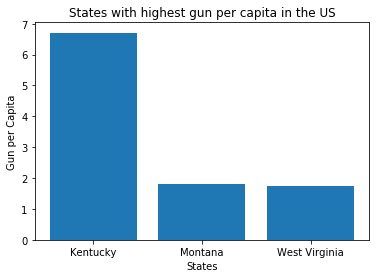

In [27]:
# create bar chart
locations = [1,2,3]
heights = [6.70782, 1.80728, 1.75244]
labels = ['Kentucky', 'Montana', 'West Virginia']
          
plt.bar(locations, heights, tick_label=labels);
plt.title('States with highest gun per capita in the US')
plt.xlabel('States')
plt.ylabel('Gun per Capita');

### Are low education, low income or high poverty associated with high gun per capita?

To answer this question, I need to build a dataframe where I have in one column the **gun per capita** (column 0), and in the other columns the statistics for **education** (column 1: % of persons age 25 years+ with bachelor's degree or higher, 2011-2015), **income** (column 2: median household income in 2015 dollars, 2011-2015), and **poverty** (column 3: % of persons in poverty, 2015). 

In [55]:
# build the dataframe with all the data needed
df_census_transposed[0] = gun_per_capita
df_census_transposed

,0,1,2,3
Alabama,1.37892,0.235,43623,0.171
Alaska,1.53343,0.28,72515,0.099
Arizona,0.638532,0.275,50255,0.164
Arkansas,1.2558,0.211,41371,0.172
California,0.484435,0.314,61818,0.143
Colorado,1.09348,0.381,60629,0.11
Connecticut,0.885829,0.376,70331,0.098
Delaware,0.516109,0.3,60509,0.117
Florida,0.567414,0.273,47507,0.147
Georgia,0.69929,0.288,49620,0.16


Then I create three scatterplots, each one comparing gun per capita with education, income and poverty levels, respectively.

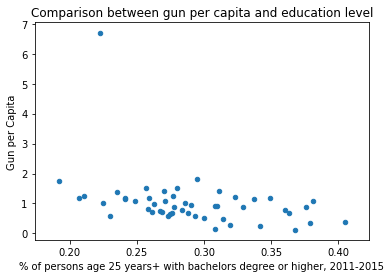

In [56]:
# change the data type to float and create a scatterplot comparing gun per capita and education level
df_census_transposed.astype('float').plot(x=1, y=0,kind='scatter');
plt.xlabel('% of persons age 25 years+ with bachelors degree or higher, 2011-2015');
plt.ylabel('Gun per Capita');
plt.title('Comparison between gun per capita and education level');

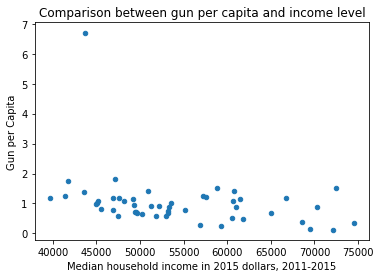

In [58]:
# change the data type to float and create a scatterplot comparing gun per capita and income level
df_census_transposed.astype('float').plot(x=2, y=0,kind='scatter');
plt.xlabel('Median household income in 2015 dollars, 2011-2015');
plt.ylabel('Gun per Capita');
plt.title('Comparison between gun per capita and income level');

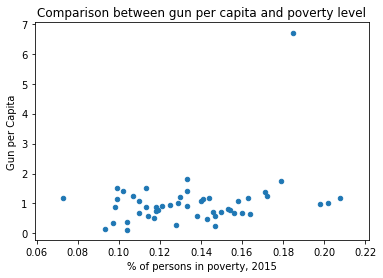

In [59]:
# change the data type to float and create a scatterplot comparing gun per capita and poverty level
df_census_transposed.astype('float').plot(x=3, y=0,kind='scatter');
plt.xlabel('% of persons in poverty, 2015');
plt.ylabel('Gun per Capita');
plt.title('Comparison between gun per capita and poverty level');

<a id='conclusions'></a>
## Conclusions

In this section, I am going to answer the questions asked at the beginning of the investigation, using the statistics that I have computed and the visualizations created.

**What is the overall trend of gun purchases?**
The bar chart called 'Historical trend of gun purchases in the US' clearly shows that gun purchases are in an upward trend since 2005. It stayed flat from 1999 to 2004, before increasing every year since until 2017. (Note that 1998 and 2017 do not contain values for the full year, hence the lower gun purchases)

**Which states have high gun per capita?**
The three states with the highest gun per capita are Kentucky, Montana, and West Virginia with 6.7, 1.8, and 1.8 guns per capita, respectively.


**Are low education, low income or high poverty associated with high gun per capita?**
Contrary to what one may think, gun per capita does not seem to be related with education, income or poverty levels. Whatever the % of people with a bachelors degree or higher, the median household income or the % of people in poverty, the gun per capita stays relatively the same, which is why the data is split equally along the x axis. (Except for Kentucky which appears to be an outlier).